In [26]:
cd ..

/home/araxal


In [27]:
import pandas as pd
import numpy as np
from utils.decade_classification import feature_preparator
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
BATCH_SIZE = 1

In [30]:
%%time
train_data_loader, test_data_loader1, test_data_loader2, idx_to_label = feature_preparator('features/decade_classification/mfcc24-zcr-sc-sr-sf-chr-flattened.p', BATCH_SIZE)

FileNotFoundError: [Errno 2] No such file or directory: 'features/decade_classification/mfcc24-zcr-sc-sr-sf-chr-flattened.p'

In [31]:
features = []

features_1 = ['mean', 'std', 'skew', 'kurtosis']
features_2 = {'mfcc': 24, 'zero_crossing_rate': 1, 'spectral centroid': 1, 'spectral rolloff': 1, 'spectral flattness': 1, 'chroma': 12}

for j in features_1:
    for feature, num in features_2.items():
        for i in range(num):
            features.append(f'{feature}_{i}_{j}')

In [32]:
def make_dataframe_from_dataloader(dataloader: DataLoader, column_names):
    all_features = []
    all_targets = []

    for features, target in dataloader:
        features = features.flatten()
        all_features.append(features.numpy())
        all_targets.append(target.numpy()[0])

    return pd.DataFrame.from_records(all_features, columns=column_names), pd.Series(all_targets)

def transform_idx_to_label(x):
    return idx_to_label[x]

In [33]:
train_df_x, train_df_y = make_dataframe_from_dataloader(train_data_loader, features)
test1_df_x, test1_df_y = make_dataframe_from_dataloader(test_data_loader1, features)
test2_df_x, test2_df_y = make_dataframe_from_dataloader(test_data_loader2, features)
test_df_x = pd.concat([test1_df_x, test2_df_x])
test_df_y = pd.concat([test1_df_y, test2_df_y])

Снижаем размерность

In [34]:
adabooost_clf = AdaBoostClassifier(n_estimators=100, random_state=111)

In [35]:
adabooost_clf.fit(train_df_x, train_df_y)

AdaBoostClassifier(n_estimators=100, random_state=111)

In [36]:
adaboost_predicted = adabooost_clf.predict(test_df_x)

              precision    recall  f1-score   support

        1990       0.40      0.45      0.42       105
        2000       0.39      0.49      0.43       102
        2010       0.42      0.36      0.39        96
         old       0.76      0.57      0.65       107

    accuracy                           0.47       410
   macro avg       0.49      0.47      0.47       410
weighted avg       0.50      0.47      0.48       410



<AxesSubplot: >

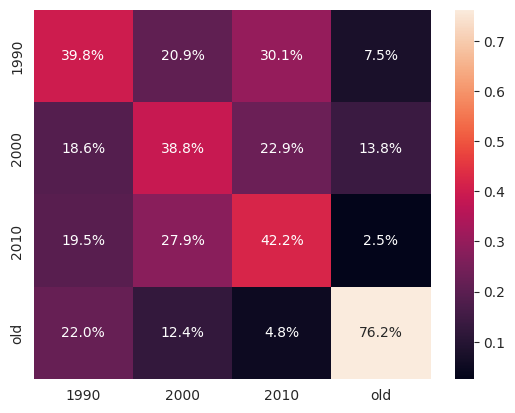

In [37]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, adaboost_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, adaboost_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%',)

In [38]:
xgb_dtrain = xgb.DMatrix(train_df_x, label = train_df_y)
xgb_dtest = xgb.DMatrix(test_df_x, label = test_df_y)
xgb_param = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 8}
xgb_num_round = 100

In [39]:
xgb_clf = xgb.train(xgb_param, xgb_dtrain, xgb_num_round)
xgb_predicted_matrix = xgb_clf.predict(xgb_dtest)
xgb_predicted = np.asarray([np.argmax(line) for line in xgb_predicted_matrix])

              precision    recall  f1-score   support

        1990       0.56      0.60      0.58       105
        2000       0.49      0.53      0.51       102
        2010       0.58      0.55      0.56        96
         old       0.82      0.74      0.78       107

    accuracy                           0.61       410
   macro avg       0.61      0.60      0.61       410
weighted avg       0.62      0.61      0.61       410



<AxesSubplot: >

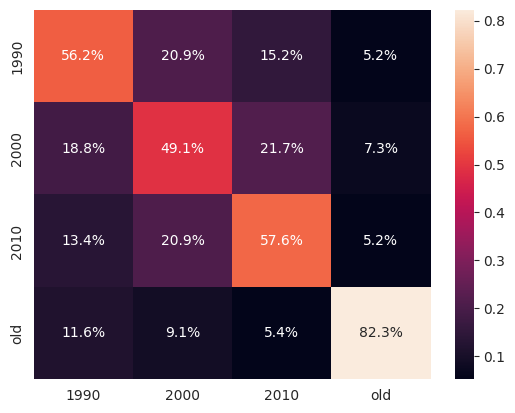

In [40]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, xgb_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, xgb_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')

In [41]:
svm_clf = SVC()
svm_clf.fit(train_df_x, train_df_y)
svm_predicted = svm_clf.predict(test_df_x)

              precision    recall  f1-score   support

        1990       0.61      0.65      0.63       105
        2000       0.47      0.61      0.53       102
        2010       0.57      0.45      0.50        96
         old       0.90      0.76      0.82       107

    accuracy                           0.62       410
   macro avg       0.64      0.62      0.62       410
weighted avg       0.64      0.62      0.62       410



<AxesSubplot: >

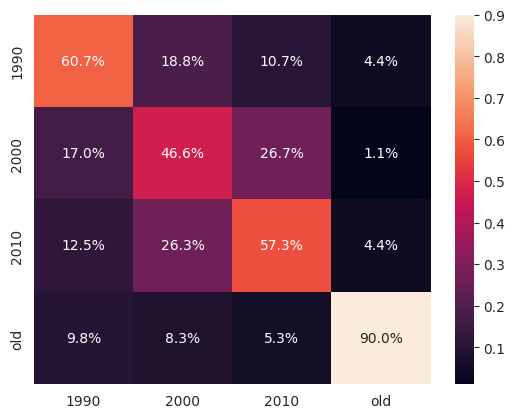

In [42]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, svm_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, svm_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')

In [43]:
cat_clf = CatBoostClassifier(logging_level='Silent')
cat_clf.fit(train_df_x, train_df_y)
cat_predicted = cat_clf.predict(test_df_x)
cat_predicted = np.ravel(cat_predicted).tolist()

              precision    recall  f1-score   support

        1990       0.61      0.61      0.61       105
        2000       0.55      0.57      0.56       102
        2010       0.57      0.56      0.57        96
         old       0.83      0.80      0.82       107

    accuracy                           0.64       410
   macro avg       0.64      0.64      0.64       410
weighted avg       0.64      0.64      0.64       410



<AxesSubplot: >

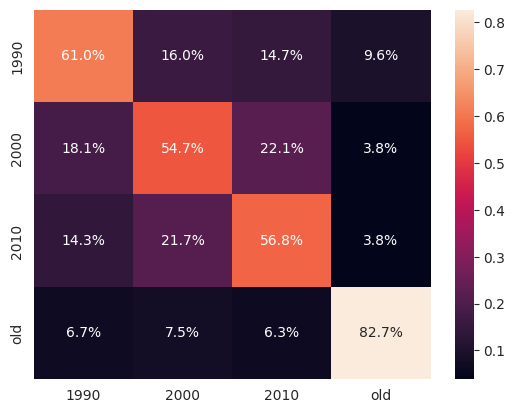

In [44]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, cat_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, cat_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')